In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from astroddpm.diffusion.power_spectra.powerspec_sampler import CMB_H_OMBH2
from astroddpm.analysis.validationMetrics.powerSpectrum import _spectral_iso2d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
save_fig = True

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)

In [4]:
ps_model = CMB_H_OMBH2().to(device)

def compute_ps(rphi):
    rphi = rphi.to(device)
    ps = ps_model(rphi, to_rescale=False)
    bins, iso_ps, _ = _spectral_iso2d(ps, bins = torch.linspace(0, np.pi, 100).to(device))
    return bins, iso_ps

In [16]:
def plot_ps(rphi, ax, title = None):
    bins, iso_ps = compute_ps(rphi.reshape(1,-1).to(device))
    ax.plot(bins.detach().cpu(), iso_ps.detach().cpu()[0])
    ax.set_title(title)
    ax.set_xscale("log")
    ax.set_yscale("log")

In [29]:
all_rphis

tensor([[-1.0000,  0.0000],
        [-0.9798,  0.0000],
        [-0.9596,  0.0000],
        [-0.9394,  0.0000],
        [-0.9192,  0.0000],
        [-0.8990,  0.0000],
        [-0.8788,  0.0000],
        [-0.8586,  0.0000],
        [-0.8384,  0.0000],
        [-0.8182,  0.0000],
        [-0.7980,  0.0000],
        [-0.7778,  0.0000],
        [-0.7576,  0.0000],
        [-0.7374,  0.0000],
        [-0.7172,  0.0000],
        [-0.6970,  0.0000],
        [-0.6768,  0.0000],
        [-0.6566,  0.0000],
        [-0.6364,  0.0000],
        [-0.6162,  0.0000],
        [-0.5960,  0.0000],
        [-0.5758,  0.0000],
        [-0.5556,  0.0000],
        [-0.5354,  0.0000],
        [-0.5152,  0.0000],
        [-0.4949,  0.0000],
        [-0.4747,  0.0000],
        [-0.4545,  0.0000],
        [-0.4343,  0.0000],
        [-0.4141,  0.0000],
        [-0.3939,  0.0000],
        [-0.3737,  0.0000],
        [-0.3535,  0.0000],
        [-0.3333,  0.0000],
        [-0.3131,  0.0000],
        [-0.2929,  0

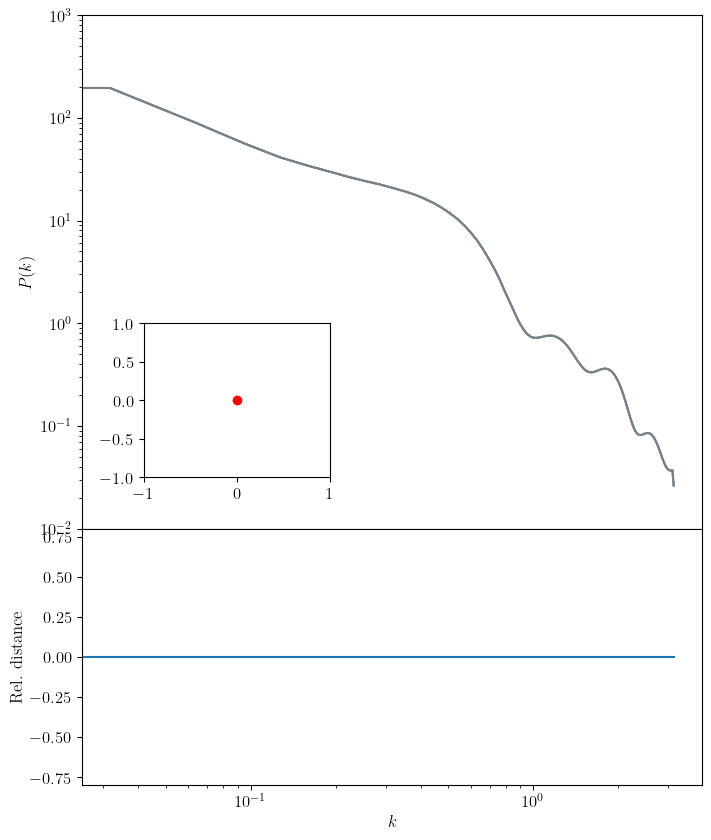

/tmp/ipykernel_3588865/2872684518.py:33: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0].clear()


In [58]:
## Create gif of how the power spectrum changes with the cosmolgical parameters. We will plot the power spectrum for phi in [-1,1] x 0 and 0 x [-1,1] 
## We will also plot in a paler color the power spectrum for phi = (0,0).
## In the lower left corner, there will be an image inside the plot with a red dot indicating the current value of phi.
## In a second subplot bellow, plot the relative error between any phi and phi = (0,0)

## Create a grid of phi values

rphi1_up = torch.linspace(0,1, 30)
rphi1_down = torch.linspace(0,-1, 30)

rphi2_up = torch.linspace(0,1, 30)
rphi2_down = torch.linspace(0,-1, 30)

rphi_list = [torch.stack((rphi1_up, torch.zeros_like(rphi1_up)), dim = 1),
            torch.stack((rphi1_up.flip(0), torch.zeros_like(rphi1_up)), dim = 1),
            torch.stack((rphi1_down, torch.zeros_like(rphi1_down)), dim = 1), 
            torch.stack((rphi1_down.flip(0), torch.zeros_like(rphi1_down)), dim = 1),
            torch.stack((torch.zeros_like(rphi2_up), rphi2_up), dim = 1), 
            torch.stack((torch.zeros_like(rphi2_up), rphi2_up.flip(0)), dim = 1), 
            torch.stack((torch.zeros_like(rphi2_down), rphi2_down), dim = 1), 
            torch.stack((torch.zeros_like(rphi2_down), rphi2_down.flip(0)), dim = 1)]

all_rphis = torch.cat(rphi_list, dim = 0)
images = []

bins, iso_ps0 = compute_ps(torch.zeros_like(all_rphis[0]).reshape(1,-1).to(device))

fig, ax = plt.subplots(2,1, figsize = (8,10), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
## Set vertical space to 0
fig.subplots_adjust(hspace=0)

for i in range(all_rphis.shape[0]):
    ax[0].clear()
    ax[1].clear()
    bins, iso_ps = compute_ps(all_rphis[i].reshape(1,-1).to(device))
    ## Create a small inset image inside ax[0] to plot the current value of phi as a red dot in the square [-1,1] x [-1,1]
    ax[0].plot(bins.detach().cpu(), iso_ps.detach().cpu()[0], label = r'$\phi = ({},{})$'.format(all_rphis[i][0].detach().cpu().numpy(), all_rphis[i][1].detach().cpu().numpy()))
    ax[0].plot(bins.detach().cpu(), iso_ps0.detach().cpu()[0], label = r'$\phi = (0,0)$', color = 'gray')
    ax[0].set_ylim(1e-2,1e3)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    axins = ax[0].inset_axes([0.1, 0.1, 0.3, 0.3])
    axins.plot(all_rphis[i][0].detach().cpu().numpy(), all_rphis[i][1].detach().cpu().numpy(), "ro")
    axins.set_xlim(-1,1)
    axins.set_ylim(-1,1)
    ax[1].set_xlabel(r'$k$')
    ax[1].set_ylabel('Rel. distance')
    ax[0].set_ylabel(r'$P(k)$')
    
    ## Plot the relative error between the current value of phi and phi = (0,0)

    ax[1].plot(bins.detach().cpu(), (iso_ps.detach().cpu()[0] - iso_ps0.detach().cpu()[0])/iso_ps0.detach().cpu()[0])
    ax[1].set_ylim(-0.8,0.8)
    plt.pause(0.1)
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    image = np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)
    image = Image.fromarray(image)
    images.append(image)

## Create the gif with PIL
from PIL import Image, ImageDraw

## change every plt image to a PIL image

images[0].save('sensitivity.gif',
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)